# 使用 diffusers 训练模型

In [ ]:
# !pip install ipywidgets

In [1]:
from huggingface_hub import notebook_login

notebook_login()

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from PIL import Image
import torchvision


def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im


def make_grid(images, size=64):
    """Given a list of PIL images, stack them together into a line for easy viewing"""
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im


# Mac users may need device = 'mps' (untested)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [1]:
# from huggingface_hub import snapshot_download
# import os
# os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"

# snapshot_download(repo_id="sd-dreambooth-library/mr-potato-head", local_dir="./model", local_dir_use_symlinks=False)

Fetching 23 files:   0%|          | 0/23 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/608M [00:00<?, ?B/s]

'G:\\code\\ai\\stable-diffusion-webui_tobe\\notebook\\model'

In [2]:
from diffusers import StableDiffusionPipeline

# https://huggingface.co/sd-dreambooth-library，这里有来自社区的各种模型
# model_id = "sd-dreambooth-library/mr-potato-head"
model_id = "G:\code\pretrain_model_dir\mr-potato-head"

# 加载管线
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16). to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

g:\code\ai\stable-diffusion-webui_tobe\venv\lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


  0%|          | 0/50 [00:00<?, ?it/s]

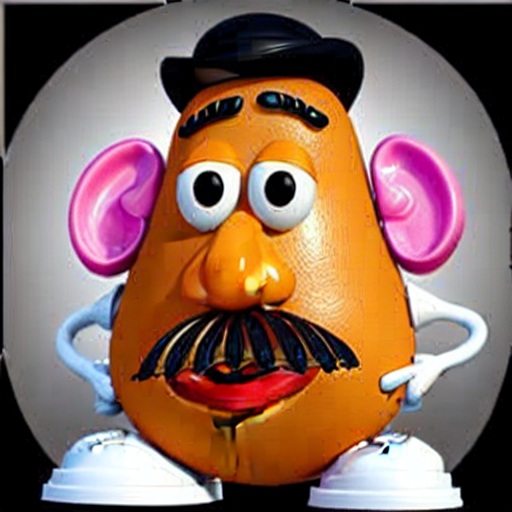

In [11]:
# 在这个示例中，sks是新引入的唯一标识符(Unique IDentif ier，UID)
prompt = "an abstract oil painting of sks mr potato head by picasso"
image = pipe(prompt, num_inference_steps=50, guidance_scale=7.5).images[0]
image

In [14]:
# from huggingface_hub import snapshot_download
# import os
# os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"

# snapshot_download(repo_id="johnowhitaker/ddpm-butterflies-32px", local_dir="./model", local_dir_use_symlinks=False)

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

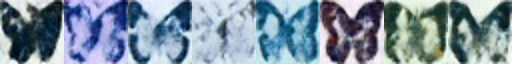

In [13]:
from diffusers import DDPMPipeline

# 加载预设好的管线
# model_id = "johnowhitaker/ddpm-butterflies-32px"
model_id = r"G:\code\pretrain_model_dir\ddpm-butterflies-32px"
butterfly_pipeline = DDPMPipeline.from_pretrained(model_id).to(device)

# 生成8张图片
images = butterfly_pipeline(batch_size=8).images

# 输出图片
make_grid(images)

# 准备数据

In [15]:
import torchvision
from datasets import load_dataset
from torchvision import transforms

dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train", cache_dir="./data/smithsonian_butterflies_subset")

# 也可以从本地文件夹中加载图像
# dataset = load_dataset("imagefolder", data_dir="path/to/folder")

# 我们将在32×32像素的正方形图像上进行训练，但你也可以尝试更大尺寸的图像
image_size = 32
# 如果GPU内存不足，你可以减小batch_size
batch_size = 64

# 定义数据增强过程
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),  # 调整大小
        transforms.RandomHorizontalFlip(),            # 随机翻转
        transforms.ToTensor(),              # 将张量映射到(0,1)区间
        transforms.Normalize([0.5], [0.5]), # 映射到(-1, 1)区间
    ]
)

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in
       examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

# 创建一个数据加载器，用于批量提供经过变换的图像
train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

g:\code\ai\stable-diffusion-webui_tobe\venv\lib\site-packages\huggingface_hub\repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

X shape: torch.Size([8, 3, 32, 32])


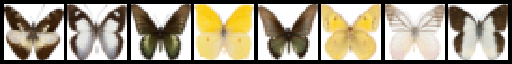

In [17]:
xb = next(iter(train_dataloader))["images"].to(device)[:8]
print("X shape:", xb.shape)
show_images(xb).resize((8 * 64, 64), resample=Image.NEAREST)

In [18]:
from diffusers import DDPMScheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

Noisy X shape torch.Size([8, 3, 32, 32])


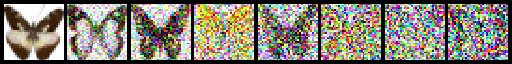

In [20]:
# 仅添加了少量噪声
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_start=0.001, beta_end=0.004)

timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb)
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print("Noisy X shape", noisy_xb.shape)
show_images(noisy_xb).resize((8 * 64, 64), resample=Image.NEAREST)

Noisy X shape torch.Size([8, 3, 32, 32])


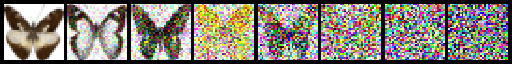

In [23]:
# 'cosine'调度方式，这种方式可能更适合尺寸较小的图像
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb)
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print("Noisy X shape", noisy_xb.shape)
show_images(noisy_xb).resize((8 * 64, 64), resample=Image.NEAREST)

# 创建模型

In [25]:
from diffusers import UNet2DModel

# 创建模型
model = UNet2DModel(
    sample_size=image_size,   # 目标图像分辨率
    in_channels=3,            # 输入通道数，对于RGB图像来说，通道数为3 
    out_channels=3,           # 输出通道数
    layers_per_block=2,       # 每个UNet块使用的ResNet层数
    block_out_channels=(64, 128, 128, 256), # 更多的通道→更多的参数
    down_block_types=(
        "DownBlock2D",        # 一个常规的ResNet下采样模块
        "DownBlock2D",
        "AttnDownBlock2D",    # 一个带有空间自注意力的ResNet下采样模块
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",      # 一个带有空间自注意力的ResNet上采样模块
        "UpBlock2D",
        "UpBlock2D",          # 一个常规的ResNet上采样模块
    ),
)
model.to(device)
print(type(model))

<class 'diffusers.models.unet_2d.UNet2DModel'>


In [26]:
with torch.no_grad():
    model_prediction = model(noisy_xb, timesteps).sample
model_prediction.shape

torch.Size([8, 3, 32, 32])

In [27]:
# 设定噪声调度器
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2"
)

# 训练循环
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)

losses = []

for epoch in range(30):
    for step, batch in enumerate(train_dataloader):
        clean_images = batch["images"].to(device)
        # 为图片添加采样噪声
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # 为每张图片随机采样一个时间步
        timesteps = torch.randint(
            0, noise_scheduler.num_train_timesteps, (bs,),
            device=clean_images.device
        ).long()

        # 根据每个时间步的噪声幅度，向清晰的图片中添加噪声
        noisy_images = noise_scheduler.add_noise(clean_images,
           noise, timesteps)

        # 获得模型的预测结果
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        # 计算损失, 比较噪声
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())

        # 迭代模型参数
        optimizer.step()
        optimizer.zero_grad()

    if (epoch + 1) % 5 == 0:
        loss_last_epoch = sum(losses[-len(train_dataloader) :]) /len(train_dataloader)
        print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")

g:\code\ai\stable-diffusion-webui_tobe\venv\lib\site-packages\diffusers\configuration_utils.py:135: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch:5, loss: 0.15379350911825895
Epoch:10, loss: 0.11292902426794171
Epoch:15, loss: 0.09834889182820916
Epoch:20, loss: 0.08060872694477439
Epoch:25, loss: 0.07384288706816733
Epoch:30, loss: 0.06933391257189214


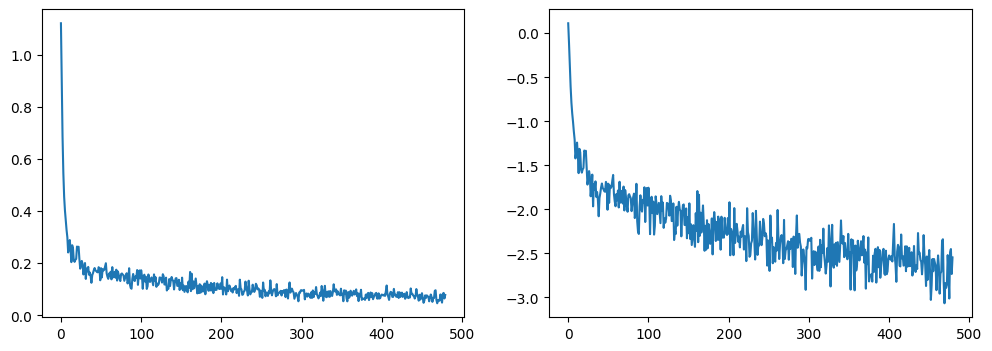

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

In [ ]:
# model = butterfly_pipeline.unet

# 生成图像

  0%|          | 0/1000 [00:00<?, ?it/s]

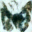

In [29]:
from diffusers import DDPMPipeline

image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)
pipeline_output = image_pipe()
pipeline_output.images[0]

In [31]:
# 保存模型
image_pipe.save_pretrained("my_pipeline")

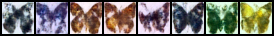

In [32]:
# 另一种生成方式, 不依赖 pipeline

# 随机初始化（8张随机图片）
sample = torch.randn(8, 3, 32, 32).to(device)

for i, t in enumerate(noise_scheduler.timesteps):

    # 获得模型的预测结果
    with torch.no_grad():
        residual = model(sample, t).sample

    # 根据预测结果更新图像 noise_scheduler.step方法可以执行更新“样本”所需的数学运算。
    sample = noise_scheduler.step(residual, t, sample).prev_sample

show_images(sample)

# 上传模型

In [1]:
from huggingface_hub import get_full_repo_name

model_name = "sd-class-butterflies-32"
hub_model_id = get_full_repo_name(model_name)
hub_model_id

'tobefan/sd-class-butterflies-32'

In [3]:
from huggingface_hub import HfApi, create_repo

create_repo(hub_model_id)
api = HfApi()
api.upload_folder(
    folder_path="my_pipeline/scheduler", path_in_repo="",
    repo_id=hub_model_id
)
api.upload_folder(folder_path="my_pipeline/unet", path_in_repo="",
    repo_id=hub_model_id)
api.upload_file(
    path_or_fileobj="my_pipeline/model_index.json",
    path_in_repo="model_index.json",
    repo_id=hub_model_id,
)

diffusion_pytorch_model.safetensors:   0%|          | 0.00/74.2M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/tobefan/sd-class-butterflies-32/commit/faa88d25aadaa5cf82ac86307e92de3a210568aa', commit_message='Upload model_index.json with huggingface_hub', commit_description='', oid='faa88d25aadaa5cf82ac86307e92de3a210568aa', pr_url=None, pr_revision=None, pr_num=None)

In [3]:
from huggingface_hub import ModelCard

content = f"""
---
license: mit
tags:
- pytorch
- diffusers
- unconditional-image-generation
- diffusion-models-class
---

# Model Card for Unit 1 of the [Diffusion Models Class 🧨](https://github.com/huggingface/diffusion-models-class)

This model is a diffusion model for unconditional image generation of cute 🦋.

## Usage

```python
from diffusers import DDPMPipeline

pipeline = DDPMPipeline.from_pretrained('{hub_model_id}')
image = pipeline().images[0]
image
```
"""

card = ModelCard(content)
card.push_to_hub(hub_model_id)

CommitInfo(commit_url='https://huggingface.co/tobefan/sd-class-butterflies-32/commit/e0b0e7c6a228843e5eaa41e373b0470f97905bf5', commit_message='Upload README.md with huggingface_hub', commit_description='', oid='e0b0e7c6a228843e5eaa41e373b0470f97905bf5', pr_url=None, pr_revision=None, pr_num=None)

In [4]:
# 加载已经上传到 hub 库里的模型
# from diffusers import DDPMPipeline

# image_pipe = DDPMPipeline.from_pretrained(hub_model_id)
# pipeline_output = image_pipe()
# pipeline_output.images[0]